In [2]:
# -*- coding: utf-8 -*-

#!/usr/bin/python
# -*- coding: utf-8 -*-

In [3]:
__author__ = 'pnovais'

# Modelos de Rotatividade

Em um cenário onde obter clientes para uma dada empresa é cada vez mais complexo, os modelos de rotatividade tentam entender como e o porquê de clientes deixarem de usufruir de um dado produto ofertado pelas empresas. Entender a rotatividade dos clientes é uma ferramenta útil para fundamentar ações que visem melhorar a relação empresa-cliente. Esses modelos são bastante utilizados, por exemplo, por empresas de telefonia, de cartões de crédito, de serviços de streaming e outros.

Os modelos mais simples de rotatividade predizem uma taxa de rotatividade como, em um dado intervalo de tempo, sendo a razão entre os clientes que abandonaram um dado produto e os clientes que se mantiveram como consumidores do mesmo. 

Na presente análise, são utilizados dados de um banco que está buscando entender a rotatividade dos seus clientes.

***
# Dataset Churn

Dataset com informações sobre a rotatividade de clientes de um banco. 

***

In [4]:
#Importando as bibliotecas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from termcolor import colored,cprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
import matplotlib.mlab as mlab

%matplotlib inline

In [5]:
ini=time.time()
plt.style.use('mystyle-paty.mplstyle')

***
# Breve reconhecimento do dataset

Abaixo, descrevemos as informações contidas no dataset **Churn**, bem como algumas estatísticas básicas tanto das variáveis contínuas quanto das variáveis categóricas.

### Informações contidas no dataset
O dataset apresenta diversas características dos clientes do banco, sendo que o significado de cada variável é descrito a seguir:

- RowNumber: numeração do dado no dataset (linha da planilha)
- CustomerId: número de identificação do cliente
- Surname: sobrenome
- CreditScore: pontuação de crédito
- Geography: localização
- Gender: genêro
- Age: idade 
- Tenure: período em que o cliente se manteve no banco
- Balance: saldo
- NumOfProducts: número de produtos contratados
- HasCrCard: se tem ou não cartão de crédito (1 - sim, 0 - não)
- IsActiveMember: se é um cliente ativo do banco (1 - sim, 0 - não)
- EstimatedSalary: salário estimado
- Exited: se saiu ou não do banco (1 - sim, 0 - não)


In [6]:
# Abrindo o dataset
df = pd.read_csv('Churn_Modelling.csv')

In [7]:
# Overview dos dados
text = colored(' >> O dataset possui informações sobre %d objetos' %len(df), 'green', attrs=['bold','underline'])
cprint(text)
df.head()

 >> O dataset possui informações sobre 10000 objetos


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- Das 14 variáveis disponíveis, temos 6 variáveis variáveis categóricas nominais:Surname, Geography, Gender, HasCrCard, IsActiveMember e Exited. (ainda que os 3 últimos apareçam no dataset como variável inteira).

In [7]:
# Convertendo as variáveis inteiras para object
df['HasCrCard'] = df['HasCrCard'].astype('object')
df['IsActiveMember'] = df['IsActiveMember'].astype('object')
df['Exited'] = df['Exited'].astype('object')

In [8]:
df.describe(include=['O'])

,Surname,Geography,Gender,HasCrCard,IsActiveMember,Exited
count,10000,10000,10000,10000,10000,10000
unique,2932,3,2,2,2,2
top,Smith,France,Male,1,1,0
freq,32,5014,5457,7055,5151,7963


In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


- Apenas com a estatística básica dos dados já é possível inferir que:

- Cerca de 50% dos clientes estão entre 32 e 44 anos, ou seja, é predominantemente clientes financeiramente ativos
- A permanência máxima nos dados foi de 10 meses ?
- A quantidade máxima de produtos que um mesmo cliente possui e 4.

***
# Distribuições dos parâmetros


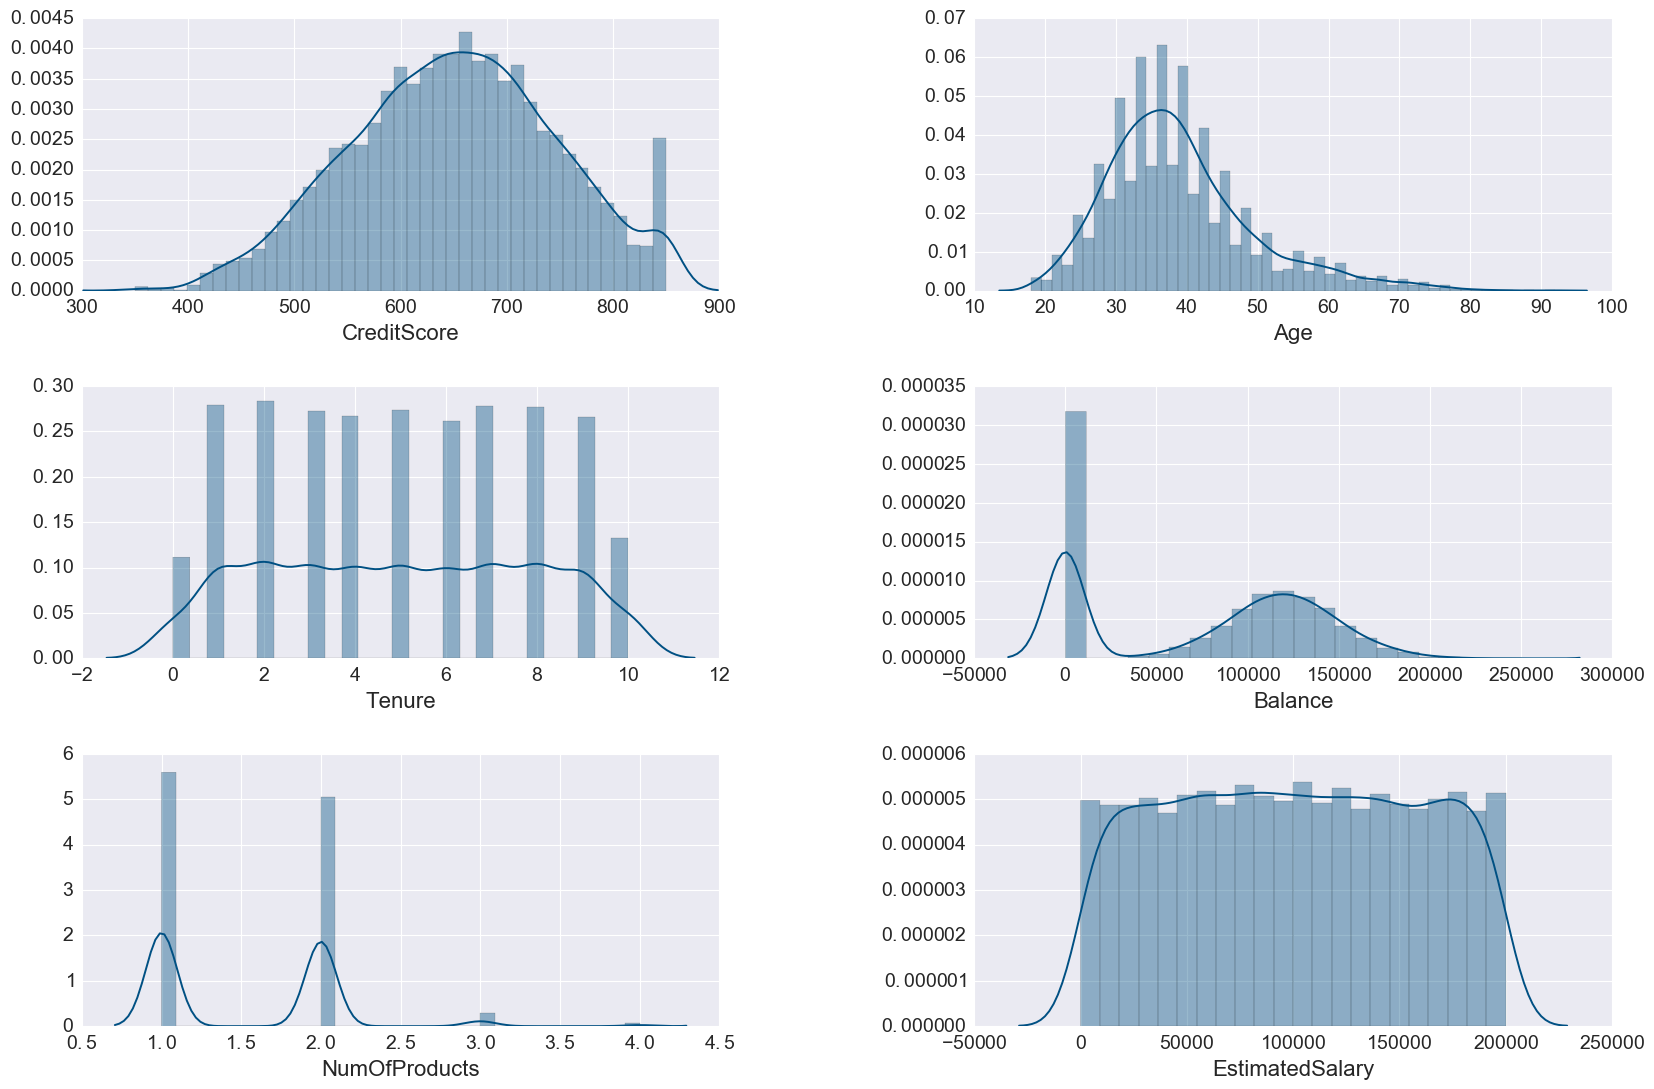

In [10]:
#Distribuição das variáveis quantitativas
features = ["CreditScore", "CreditScore", "Age", "Tenure", "Balance",
             "NumOfProducts", "EstimatedSalary"]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for col, ax in zip(features[1:], axs.ravel()):
    x=df.loc[:,col]
    sns.distplot(x, ax=ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.4)

- A distribuição do Score é quase gaussiano, com média em torno de 650
- A distribuição da idade também quase gaussiana, exceto pela asa direita que é mais alongada do que a esquerda. O valor médio de idade está em torno de 38 anos
- Há quase a mesma proporção de clientes em todos os valores de Tenure, exceto para Ternure = 0 e Ternure = 10
- Há uma quantidade considerável de clientes com saldo nulo, enquanto que a distribuição dos demais também parece ser gaussiana
- A maioria dos clientes possuem 1 ou 2 produtos do banco
- Os salários estimadores possuem quase a mesma quantidade de clientes por faixa estimada no histograma.

***
# Binagem

**>** Observando a distribuição dos parâmetros acima e a correlação entre eles (abaixo), podemos notar que há a necessidade de binar os dados, de forma a melhorar não apenas a visualização mas também a análise a ser feita.

**>** Assim, binaremos os dados da seguinte forma:
- Idade:
    - age < 18 : menores e financeiramente inativos
    - 19 < age < 25 : financeiramente ativos mas provavelmente sem renda fixa
    - 26 < age > 35 : financeiramente ativos e com provável renda fixa
    - 36 < age > 55 : financeiramente ativos e estáveis
    - age > 55 : financeiramente ativos e muito estáveis
- Score de crédito:
    - 350 - 550 : baixo crédito
    - 551 - 700 : crédito mediano
    - 701 - 850 : ótimo crédito
- Salário estimado:
    - < 50000
    - 50001 - 100000
    - 100001 - 150000
    - 150001 - 200000
- Balance:
    - < 50000
    - 50001 - 100000
    - 100001 - 150000
    - 150001 - 200000
    - 200001 - 251000

In [11]:
df_est = df.copy() #dataset estratificado

In [12]:
# Binando Age

df_est.loc[df_est["Age"] <= 18, "Idade"] = int(0)
df_est.loc[(df_est["Age"] > 18) & (df_est["Age"] <= 25), "Idade"] = int(1)
df_est.loc[(df_est["Age"] > 25) & (df_est["Age"] <= 35), "Idade"] = int(2)
df_est.loc[(df_est["Age"] > 35) & (df_est["Age"] <= 55), "Idade"] = int(3)
df_est.loc[(df_est["Age"] > 55), "Idade"] = int(4)

# Binando Score

df_est.loc[df_est["CreditScore"] <= 550, "Score"] = 1
df_est.loc[(df_est["CreditScore"] > 550) & (df_est["CreditScore"] <= 700), "Score"] = 2
df_est.loc[(df_est["CreditScore"] > 700) & (df_est["CreditScore"] <= 850), "Score"] = 3

# Binando EstimatedSalary
df_est.loc[df_est["EstimatedSalary"] <= 50000, "salario"] = 1
df_est.loc[(df_est["EstimatedSalary"] > 50000) & (df_est["EstimatedSalary"] <= 100000), "salario"] = 2
df_est.loc[(df_est["EstimatedSalary"] > 100000) & (df_est["EstimatedSalary"] <= 150000), "salario"] = 3
df_est.loc[(df_est["EstimatedSalary"] > 150000), "salario"] = 4

# Binando Balance

df_est.loc[df_est["Balance"] <= 50000, "saldo"] = 1
df_est.loc[(df_est["Balance"] > 50000) & (df_est["Balance"] <= 100000), "saldo"] = 2
df_est.loc[(df_est["Balance"] > 100000) & (df_est["Balance"] <= 150000), "saldo"] = 3
df_est.loc[(df_est["Balance"] > 150000) & (df_est["Balance"] <= 200000), "saldo"] = 4
df_est.loc[(df_est["Balance"] > 200000), "saldo"] = 5

**>** Agora que as variáveis idade, score, salário e saldo foram binadas, podemos analisar novamente as suas distribuições:

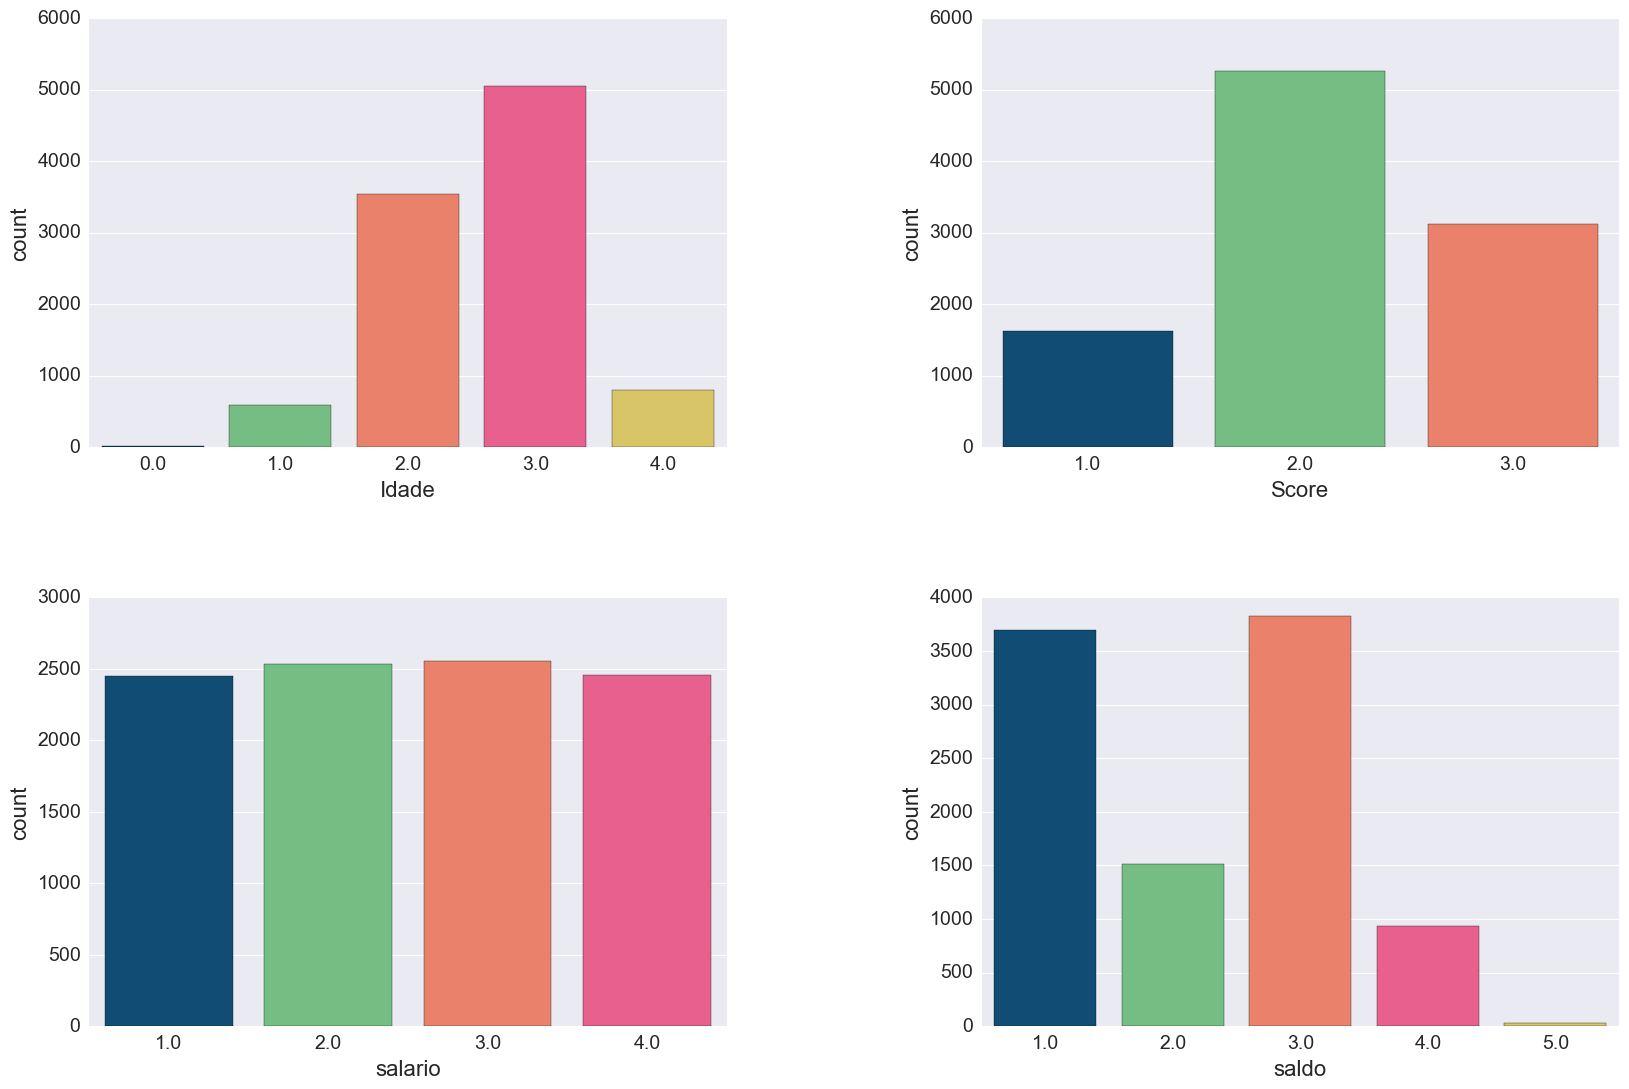

In [13]:
#Distribuição das variáveis quantitativas
features2 = ["Idade","Idade","Score", "salario", "saldo"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
for col, ax in zip(features2[1:], axs.ravel()):
    x=df_est.loc[:,col]
    sns.countplot(x, ax=ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.4)

- A maior parte dos clientes possuem idade entre 25 e 55 (idade = 2 e 3)
- Cerca de metade dos clientes possuem score médio (score = 2)
- Cerca de 2/3 dos clientes estão divididos entre os saldos 1 e 3
- Dado a binagem, a proporção das 4 faixas salariais é aproximadamente igual.

**>** Separando por gênero

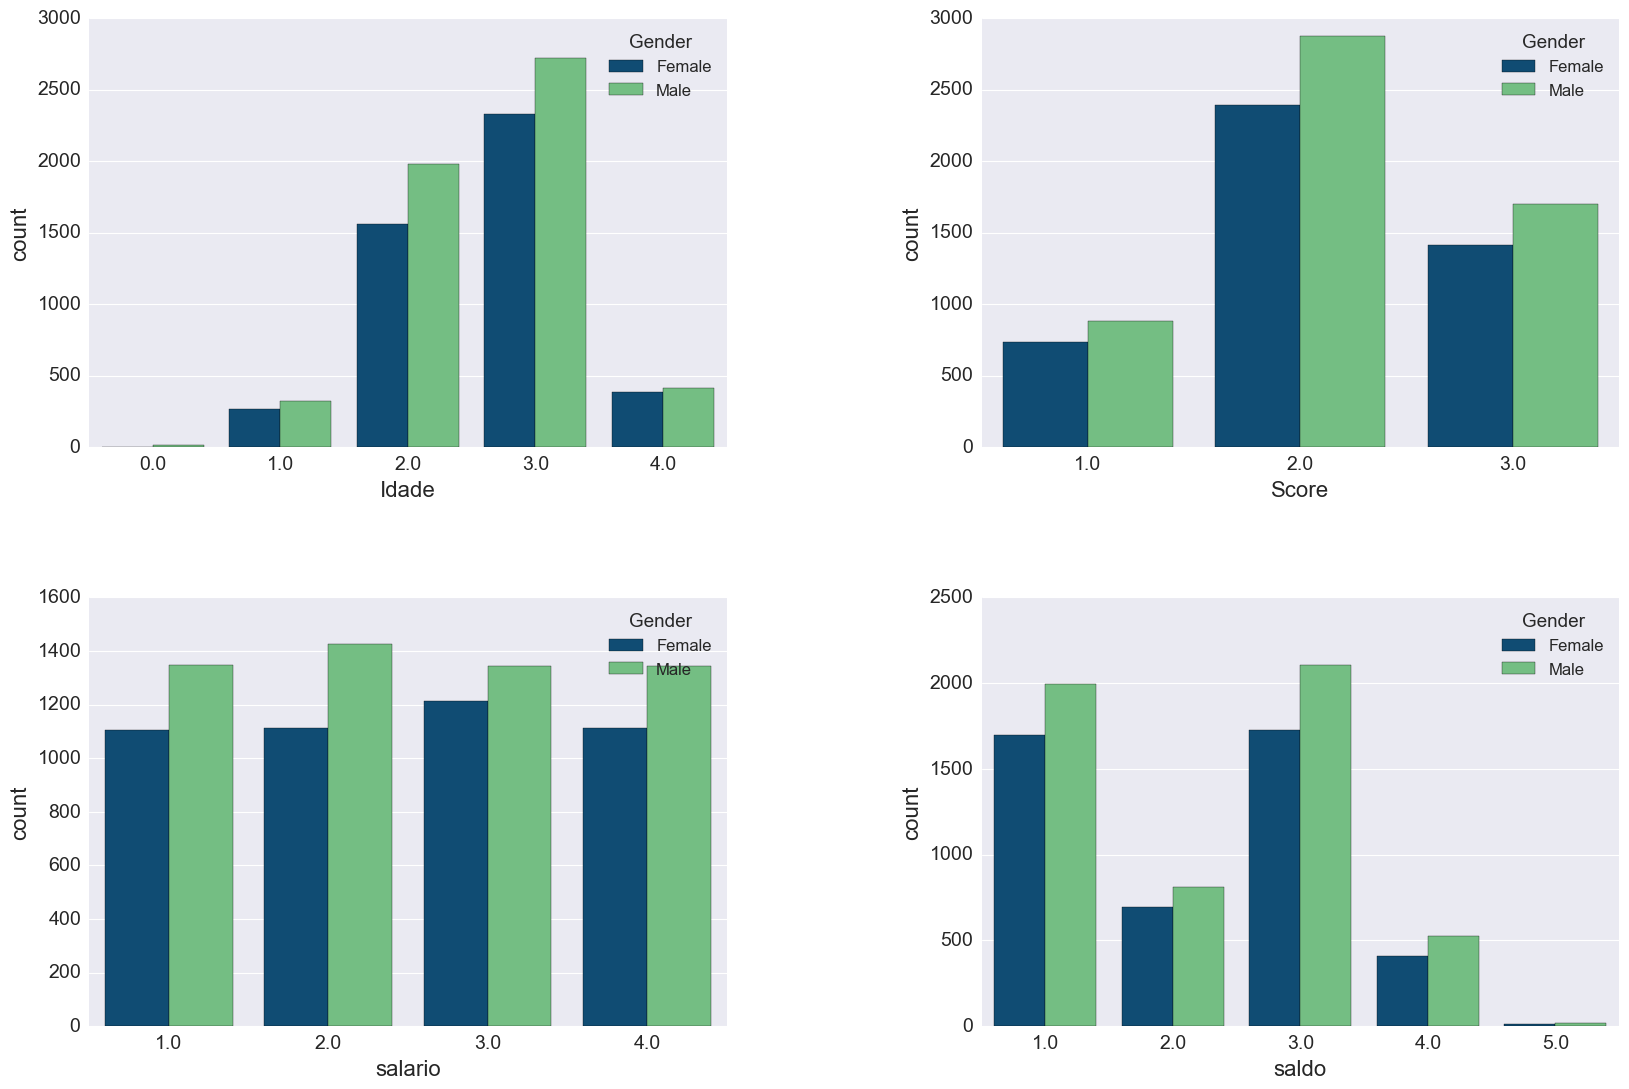

In [14]:
#Distribuição das variáveis quantitativas
features2 = ["Idade","Idade","Score", "salario", "saldo"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
for col, ax in zip(features2[1:], axs.ravel()):
    x=df_est.loc[:,col]
    sns.countplot(x, hue=df_est['Gender'], ax=ax)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.4)

- A proporção de mulheres em todas as faixas etárias, score, salariais e saldo é menor do que de homens 

In [15]:
# Transformando a variável Geography para uma variável inteira

df['paises'] = df['Geography']

df_Germ = df.loc[df.Geography=='Germany']
df_Fra = df.loc[df.Geography=='France']
df_Spa = df.loc[df.Geography=='Spain']

df_Germ.paises = 1
df_Fra.paises = 2
df_Spa.paises = 3

df_geo = pd.concat([df_Germ, df_Fra], axis = 0)
df_geo = pd.concat([df_geo,df_Spa], axis = 0)

df_geo = df_geo.sort_values(by='RowNumber')
df_geo = df_geo.reset_index()
del df_geo['index']

/Users/pnovais/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


/Users/pnovais/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


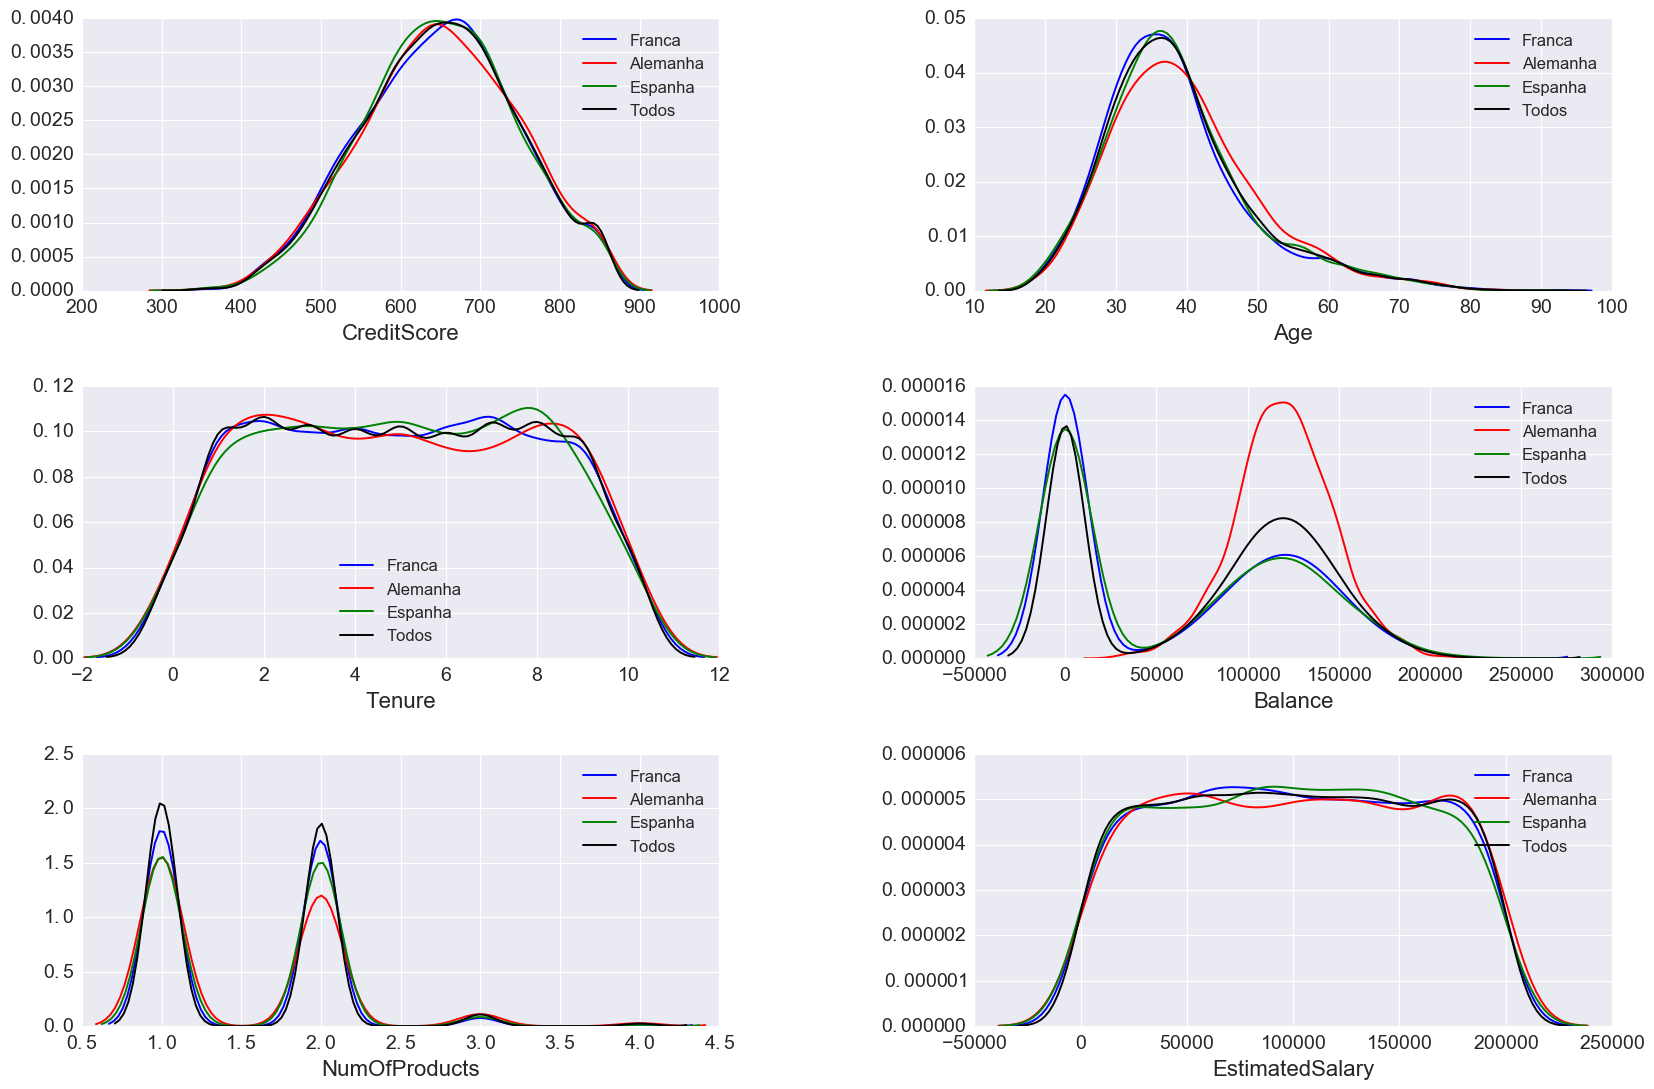

In [16]:
#Distribuição das variáveis quantitativas
features = ["CreditScore", "CreditScore", "Age", "Tenure", "Balance",
             "NumOfProducts", "EstimatedSalary"]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
for col, ax in zip(features[1:], axs.ravel()):
    x=df_Fra.loc[:,col]
    sns.distplot(x, ax=ax, hist=False, color='blue', label='Franca')
    y=df_Germ.loc[:,col]
    sns.distplot(y, ax=ax, hist=False, color='red', label='Alemanha')
    z=df_Spa.loc[:,col]
    sns.distplot(z, ax=ax, hist=False, color='green', label='Espanha')
    xx=df.loc[:,col]
    sns.distplot(xx, ax=ax, hist=False, color='black', label='Todos')
    plt.legend()
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.4)

- É interessante notar que as distribuições tem o formato muito parecido para todas as regiões.
- A Alemanha é a única região que não tem um grande pico de saldos nulos.
- A Alemanha tem um público levemente mais velho que os demais

***
# Taxa de Rotatividade

**>** A maneira mais simples de calcular a taxa de rotatividade é através da razão entre a quantidade de clientes que deixaram de utilizar um produto do banco e a quantidade de clientes que continuaram a utilizar, em um intervalo de tempo.

- Intervalo de tempo: vamos considerar o valor máximo de Tenure, que seria 10 meses (?)

$taxa = \frac{Exited=1}{Exited=0}$

In [17]:
# Definindo uma função para calcular a taxa de rotatividade
def churn(df,criterio,valor):
    df = df.loc[df[criterio]==valor]
    saida = (len(df.loc[(df.Exited==1)]))*1.0
    permanencia = (len(df))*1.0-saida
    taxa= saida/permanencia
    return taxa
    

### Taxa total

In [18]:
saida_total = (len(df.loc[df.Exited==1]))*1.0
permanencia_total = (len(df))*1.0-saida_total
taxa_total = saida_total/permanencia_total
taxa_total

0.25580811252040686

- A taxa de rotatividade total no período foi de cerca de 25,5%. **>** Para cada 4 clientes que permanecem, 1 cliente deixa de usar o produto

### Taxa por região
Agora iremos analisar quais são as taxas de rotatividade para cada uma das 3 regiões onde o produto é oferecido: Alemanha, França e Espanha

**Alemanha**

In [19]:
taxa_germ = churn(df_geo,'paises',1)
taxa_germ

0.48023598820059

- A taxa de rotatividade na Alemanha no período foi de cerca de 48%. **>** Para cada 2 clientes que permanecem, 1 cliente deixa de usar o produto

**França**

In [20]:
taxa_fra = churn(df_geo,'paises',2)
taxa_fra

0.19267364414843008

- A taxa de rotatividade na França no período foi de cerca de 20%. **>** Para cada 5 clientes que permanecem, 1 cliente deixa de usar o produto

**Espanha**

In [21]:
taxa_spa = churn(df_geo,'paises',3)
taxa_spa

0.2000968992248062

- A taxa de rotatividade na Espanha no período foi de cerca de 20%. **>** Para cada 5 clientes que permanecem, 1 cliente deixa de usar o produto

**>** A taxa de rotatividade é maior na Alemanha do que na França e Espanha, sendo a taxa dos dois últimos muito similar.

### Taxa por gênero
Agora iremos analisar quais são as taxas de rotatividade em função do gênero

**Público Feminino**

In [22]:
taxa_fem = churn(df,'Gender','Female')
taxa_fem

0.33460634547591067

**Público Masculino**

In [23]:
taxa_masc = churn(df,'Gender','Male')
taxa_masc

0.19697302039921036

- A taxa de rotatividade dentro do público feminino foi de ~33% **>** para cada 3 mulheres que permanecem, 1 deixa de usar o produto
- Já dentro do público masculino, essa taxa cai para ~20% **>** para cada 5 homens que permanecem, 1 deixa de usar o produto

**Obervação:** É importante notar que foram calculadas a taxa de rotação dentro do público feminino(masculino) e não a quantidade de mulheres(homens) dentre os que deixaram de usar o produto.

### Taxa por Faixa de Idade
Agora iremos analisar quais são as taxas de rotatividade em função da faixa etária

**Faixa 0: < 18 anos**

In [24]:
taxa_age0 = churn(df_est,'Idade',0)
taxa_age0

0.1

**Faixa 1: 19 - 25 anos**

In [25]:
taxa_age1 = churn(df_est,'Idade',1)
taxa_age1

0.08073394495412844

**Faixa 1: 26- 35 anos**

In [26]:
taxa_age2 = churn(df_est,'Idade',2)
taxa_age2

0.09287257019438445

**Faixa 1: 35- 55 anos**

In [27]:
taxa_age3 = churn(df_est,'Idade',3)
taxa_age3

0.38236099698712683

**Faixa 1: > 55 anos**

In [28]:
taxa_age4 = churn(df_est,'Idade',4)
taxa_age4

0.5810276679841897

**>** Interessante notar que rotatividade é muito maior em faixas etárias maiores

### Taxa por Faixa Salarial
Agora iremos analisar quais são as taxas de rotatividade em função da faixa salarial

**Faixa 1: < 50000**

In [29]:
taxa_sal1 = churn(df_est,'salario',1)
taxa_sal1

0.2489816700610998

**Faixa 2: < 50001 - 100000**

In [30]:
taxa_sal2 = churn(df_est,'salario',2)
taxa_sal2

0.24790949335956713

**Faixa 3: < 100001 - 150000**

In [31]:
taxa_sal3 = churn(df_est,'salario',3)
taxa_sal3

0.2536800785083415

**Faixa 4: .> 150001**

In [32]:
taxa_sal4 = churn(df_est,'salario',4)
taxa_sal4

0.2733402489626556

***
# Resumo das conclusões

- O dataset apresenta diversas informações sobre clientes que usaram ou ainda usam um determinado produto de um banco
- Esses clientes têm uma idade média de 38 anos, score médio de 650 (score razoável), cujos saldos em conta possuem 2 picos na distribuição, um em saldo zero e outro em saldo ~125000
- Fazendo uma binagem dos dados, nota-se que cerca de 50% dos clientes têm idades entre 35 e 55 anos, ou seja, são clientes que tendem a ser mais estáveis financeiramente. Além disso, independente de qual seja a binagem, o público feminino é menor em todas elas

**Rotatividade**
- Total e por países
    - Total: 0.25
    - Alemanha: 0.48
    - França: 0.19
    - Espanha: 0.20
    
**>** Assim, apesar da taxa de rotatividade total ser de 25%, a rotatividade na Alemanha supera a da França e da Espanha por quase um fator 2.5.
    
- Por gênero
    - Homens: 0.20
    - Mulheres: 0.33
    
**>**  Ainda, vemos que a rotatividade é maior dentro do público feminino.  
 
- Por idade:
        - < 18: 0.1
        - 19-25: 0.08
        - 26-35: 0.09
        - 35-55: 0.38
        - .> 55: 0.58

**>** A estratificação pela idade mostra um resultado interessante: os clientes mais velhos são os com maior taxa de rotatividade!

- Por faixa salarial:
    - < 50000: 0.25
    - 50001 - 10000: 0.25
    - 100001 - 150000: 0.25
    - .> 150001: 027

**>** A estratificação pela faixa salarial não mostrou diferenças significativas na taxa de rotatividade

- **Os resultados acima trazem informações importantes e que podem ser utilizadas para que o dado banco possa traçar estratégias que foquem os grupos com maior propensão a deixar de consumir o produto oferecido.**

In [33]:
fim = time.time()
time_proc = fim - ini
print('')
#print(bcolors.FAIL +'-'*79+ bcolors.ENDC)
print('-------------------')
print('tempo de processamento: %fmin' %(time_proc/60))
print('-------------------')
today = datetime.datetime.now()
print('Hoje é %s/%s/%s, às %s:%s' %(today.day,today.month, today.year, today.hour, today.minute))


-------------------
tempo de processamento: 0.391121min
-------------------
Hoje é 9/5/2018, às 17:26
